#### Work in Progress (4/21/22) 
* I consider this notebook to be a work in progress, because even though the examples below could be considered complete, I want to add more details to better enable a novice to take the code below and build something with it. Additionally, I want to add at least one more face detection details, show how MTCNN alters the color scheme of the photos a few other items. That being said, the below is enough to be informative. 

This notebook is very loosely based on a presentation I did for a customer around an evaluation of various machine learning technologies for detecting faces in video streams or photos. For the most part the below is an illustration around how certain face detection technologies can be easily thrown off if the subject is looking in a particular direction, wearing a hat, has a beard, etc. I.e. it's very easy to find examples that certain face detection technologies will struggle with. For the sake of expediency I didn't include all the technologies reviewed or even discussed, just three I think are interesting, including the one we recommended. 
This notebook is far more detailed than what I used in my presentation, so it's also a good tutorial for learning how to implement your own face detector. 

The examined models are "pre-trained" in that they've already been trained on a large number of faces, and can be used "out of the box" for a demonstration like this and "can" be used for many commercial applications as well. HOWEVER, given the recurring problem of facial recognition models being trained on fairly homegenous datasets, it would be wise to "fine-tune" the model, where instead of retraining it from scratch, you effectively "augment" it with new data in order to increase its effectiveness for your use case. 

In [1]:
# import our file libraries 

%matplotlib inline
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import time
import cv2
import torchvision
import torchvision.transforms as T 
import numpy as np

# import helper classes 
# these are external python scripts that I push a lot of code to make this notebook easier to read
from processing import ImageProcessing as preprocess
from helper import Helper as helper 

In [2]:
#instantiate the image processing class 
image_processing = preprocess()

#instantiate the helper class 
helper_functions = helper()


Running on device: cpu


In [3]:
# sample files 
# add more examples 

picard = 'images/picard_hair.jpg'
zebra = 'images/zebra.jpg'
kd = 'images/KD.jpeg'
jlo = 'images/jlo.jpeg'
picard_hat = 'images/picard_hat.jpg'


#### We'll start with Haar Cascade via OpenCV

* OpenCV is a Python library originally created by Intel for photo processing and computer vision. It's been around for over 20 years and is still being updated, despite it's limitations it's easy to use and effective enough for most scenarios
* Haar Cascade is a facial detection approach that is around 20 years old and it has issues with false positives, off axis photos/photos where the person isn't looking directly into the camera. However, given that it was created when hardware was significantly slower than it is now, it is very fast on modern hardware and still has its place in modern solutions. 





In [4]:
# first we create the model
# the XML file has the "pretrained" model data that enables the model to detect a face 
# there are actually a number of different data files, e.g. one that detects eyes that you can use to augment
# your detections, but for the sake of this demo, we'll just focus on generating the box around the person's face. 

# create the model 
detector = cv2.CascadeClassifier('hcdata/haarcascade_frontalface_default.xml') # creates the model 




In [5]:
# this function will use the model to a) detect the face b) put a bounding box around the face


def face_cascade(photo):
    # read in image and convert to grayscale
    img = cv2.imread(photo)
    grayscale_photo = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # detect faces 
    faces = detector.detectMultiScale(grayscale_photo, 1.3, 5)
    
    if len(faces): #check for empty list for instance where no face detected 
        print(faces)
        for (x,y,w,h) in faces:
            return cv2.rectangle(grayscale_photo,(x,y),(x+w,y+h),(255,0,0),2)        
    else:
        return img 


[[ 55  83 149 149]]
CPU times: user 662 ms, sys: 34.5 ms, total: 696 ms
Wall time: 224 ms


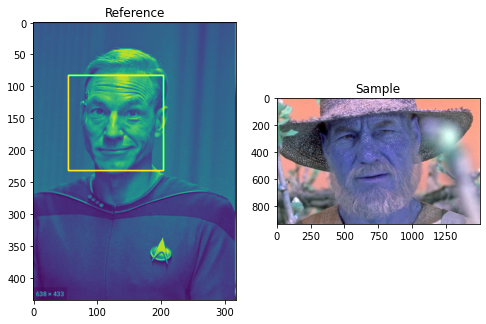

In [6]:
%%time

# now we will run face detection and generate bounding boxes for two photos
# the colors will be a bit wonky because of how openCV shifts the colors of the photos
# prior to running facial detection. Note: it's relatively easy to shift the colors back to
# normal

a = face_cascade(picard)
b = face_cascade(picard_hat)
helper_functions.plot_images(a, b)

As you can see the model detected Captain Picard's face in the first photo, but not in the second photo. This is because the beard, the hat and the foilage stymied the model. Let's look at another example 

[[413 202 456 456]]
CPU times: user 854 ms, sys: 29.2 ms, total: 883 ms
Wall time: 224 ms


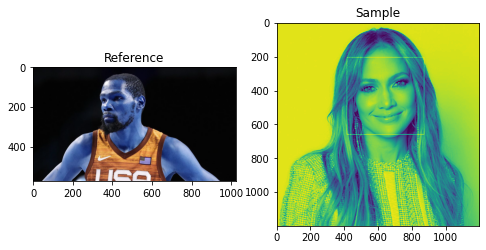

In [7]:
%%time

a = face_cascade(kd)
b = face_cascade(jlo)
helper_functions.plot_images(a, b)

In this example, the model had no problems detecting J. Lo's face, but struggle with Kevin Durant's because he's looking to our left, his right. It's worth noting that while Haar Cascade can still score in the low 90% range on a group of photos as far as accurately detecting faces, it's fairly easy to find a photo that will cause it to return a false negative. I.e. I just Googled celebrities and picked one of KD looking to his right and another with Picard wearing a hat. Still, if all you needed to do was trigger a camera to take a photo or trip some other sort of sensor when someone walked past a camera AND it was just meant to augment the efforts of humans monitoring the same area, you could still build an effective solution with haar cascade. 

In [8]:
# let's look at the MTCNN neural network approach for detecting faces 
# the knock on MTCNN is that it can be very slow, however, the below is the
# facenet-pytorch version, which is relativly fast, especially if you use GPU acceleration 
# you can use "help(MTCNN)"" to find out details on the hyperparameters below and all the different ways
# you can implement it 


mtcnn = MTCNN(160, 30, 20, [0.6, 0.7, 0.7], 0.709, True, True, 'Largest', False).eval()


In [9]:
def mtcnn_detector(file_path):
    photo = Image.open(file_path)
    
    boxes, probs, points = mtcnn.detect(photo, landmarks=True)
    img_draw = photo.copy()
    draw = ImageDraw.Draw(img_draw)
    for i, (box, point) in enumerate(zip(boxes, points)):
        draw.rectangle(box.tolist(), width=5)
        for p in point:
            draw.rectangle((p - 10).tolist() + (p + 10).tolist(), width=10)
    plt.imshow(img_draw)

CPU times: user 321 ms, sys: 70 ms, total: 391 ms
Wall time: 251 ms


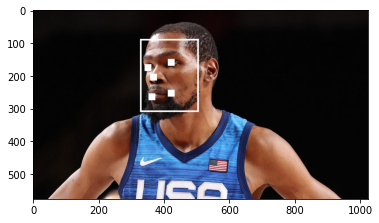

In [10]:
%%time
# what happens if we try and run face detection on KD?

x = mtcnn_detector(kd)

CPU times: user 943 ms, sys: 196 ms, total: 1.14 s
Wall time: 689 ms


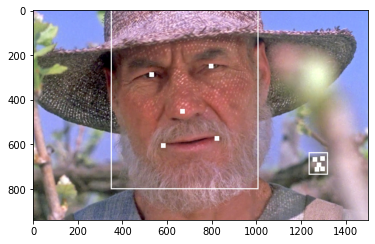

In [11]:
%%time

# what if we try to generate detection on Picard in the hat?
x = mtcnn_detector(picard_hat)



It's worth noting that we do have the small box to the right, which is definitely a false positive, but, in a photo recognition scenario we can use hyperparameters (select largest=True) to throw that result away. 

One of the reasons that MTCNN performs so much better than Haar Cascade is because it's actually three different neural nets performing in sequence, the first determines where a bounding boxes should go (if any at all) and the next two neural nets fine tune the x, y coordinates of the bounding box, facial landmarks and the like. 

#### What about speed?

As was mentioned before, Haar Cascade is significantly faster than MTCNN, what does that look like in real life? Let's illustrate this via looking at wall times for detecting a face in the same image. In the examples below, we'll just run the code to detect faces, but won't run the code to 

In [12]:
%%time 

# detect a face in the Picard with hair image 

a = face_cascade(picard)

[[ 55  83 149 149]]
CPU times: user 41.1 ms, sys: 2.16 ms, total: 43.3 ms
Wall time: 13.2 ms


In [13]:
%%time

# MTCNN requires use to use the Pillow library to read in the file and convert it to a blob 
# before passing it to the detector 

photo = Image.open(picard)
boxes, probs, points = mtcnn.detect(photo, landmarks=True)


CPU times: user 81.1 ms, sys: 12.6 ms, total: 93.7 ms
Wall time: 61.3 ms


As we can see, Haar Cascade is nearly 5x as fast as MTCNN when run on my fairly typical developer's MacBook. I.e. the increased accuracy comes with a price. 


#### References: 
* [Facenet-Pytorch](https://github.com/timesler/facenet-pytorch)
* [Pyimagesearch](https://pyimagesearch.com/start-here/) 